# Few-shot learning - Omniglot - Fellowship.ai

## Context

#### Fellowship.ai - Few-shot learning
This is my personal project to the few-shot learning challenge from [Fellowship.ai](https://fellowship.ai/challenge/) with the following goal:
> Omniglot, the “transpose” of MNIST, with 1623 character classes, each with 20 examples.  Build a few-shot classifier with a target of <35% error.

#### Omniglot - Dataset
*Dataset reference:* [Link](https://github.com/brendenlake/omniglot)
> Lake, B. M., Salakhutdinov, R., and Tenenbaum, J. B. (2015). Human-level concept learning through probabilistic program induction. Science, 350(6266), 1332-1338.

The Omniglot dataset is often considered as the transpose of the MNIST dataset. While the latter contains only 10 classes with a training set of 60000 examples, Omniglot contains an important number of classes (1623 different handwritten characters from 50 different alphabets) with only a low number of examples (20) for each, making it an ideal dataset for few-shot learning problems.

#### Few-shot learning
Whereas, lots of deep learning projects are based on a huge number of training examples to be trained, few-shot learning is  based only on a few one. This approach is much closer to the one experienced by humans. We are able to memorize and recognize objects we have never seen before from a few number of examples. Then for each new encounter with these types of object we can classify them in an accurate and easy way.


#### Stategy





## Main Goal

### Import libraries

In [1]:
import os

import tensorflow as tf
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, concatenate, MaxPooling2D, Dropout, Lambda
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers

from sklearn.model_selection import train_test_split

from PIL import Image                                                                                                                               
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.transform import resize
import h5py


%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\Xyrion\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### PATH

We indicate the PATH of the training examples.

In [2]:
#Training images path
PATH="images_background/"

#Validation and test images path
PATH_TEST = "images_evaluation/"

### Data Analysis

We have a look at the list of all alphabets contained in the training set, and their total number.

In [3]:
alph_type = np.array(os.listdir(PATH)) #Give the different types of alphabet in our data
print("List of the different alphabets:\n\n {}".format(alph_type))
print("\nNumber of different alphabets: {}".format(len(alph_type)))

List of the different alphabets:

 ['Alphabet_of_the_Magi' 'Anglo-Saxon_Futhorc' 'Arcadian' 'Armenian'
 'Asomtavruli_(Georgian)' 'Balinese' 'Bengali'
 'Blackfoot_(Canadian_Aboriginal_Syllabics)' 'Braille' 'Burmese_(Myanmar)'
 'Cyrillic' 'Early_Aramaic' 'Futurama' 'Grantha' 'Greek' 'Gujarati'
 'Hebrew' 'Inuktitut_(Canadian_Aboriginal_Syllabics)'
 'Japanese_(hiragana)' 'Japanese_(katakana)' 'Korean' 'Latin'
 'Malay_(Jawi_-_Arabic)' 'Mkhedruli_(Georgian)' 'N_Ko'
 'Ojibwe_(Canadian_Aboriginal_Syllabics)' 'Sanskrit' 'Syriac_(Estrangelo)'
 'Tagalog' 'Tifinagh']

Number of different alphabets: 30


We then check the number of character for each alphabets.

In [4]:
alph_num_char ={}
for alphabet in alph_type:
    alph_num_char[alphabet]= len(os.listdir(f'{PATH}{alphabet}'))
print("The number of chracters corresponding to each alphabet is : \n{}".format(alph_num_char))

num_of_char = alph_num_char.values()
print('\nThe maximum number of different character for one alphabet is {}'.format(max(num_of_char)))
print('The minimum number of different character for one alphabet is {}'.format(min(num_of_char)))
total_char = sum(num_of_char)
print('The total number of different character is {}'.format(total_char))

The number of chracters corresponding to each alphabet is : 
{'Alphabet_of_the_Magi': 20, 'Anglo-Saxon_Futhorc': 29, 'Arcadian': 26, 'Armenian': 41, 'Asomtavruli_(Georgian)': 40, 'Balinese': 24, 'Bengali': 46, 'Blackfoot_(Canadian_Aboriginal_Syllabics)': 14, 'Braille': 26, 'Burmese_(Myanmar)': 34, 'Cyrillic': 33, 'Early_Aramaic': 22, 'Futurama': 26, 'Grantha': 43, 'Greek': 24, 'Gujarati': 48, 'Hebrew': 22, 'Inuktitut_(Canadian_Aboriginal_Syllabics)': 16, 'Japanese_(hiragana)': 52, 'Japanese_(katakana)': 47, 'Korean': 40, 'Latin': 26, 'Malay_(Jawi_-_Arabic)': 40, 'Mkhedruli_(Georgian)': 41, 'N_Ko': 33, 'Ojibwe_(Canadian_Aboriginal_Syllabics)': 14, 'Sanskrit': 42, 'Syriac_(Estrangelo)': 23, 'Tagalog': 17, 'Tifinagh': 55}

The maximum number of different character for one alphabet is 55
The minimum number of different character for one alphabet is 14
The total number of different character is 964


In [5]:
alph_num_char_ex={}
class_num=0
for alphabet in alph_type:
    char_list=os.listdir(f'{PATH}{alphabet}')
    for char in char_list:
        alph_num_char_ex[(alphabet,char)]= len(os.listdir(f'{PATH}{alphabet}/{char}'))

num_of_example = alph_num_char_ex.values()
print('The maximum number of different examples for one character is {}'.format(max(num_of_example)))
print('The minimum number of different examples for one character is {}'.format(min(num_of_example)))
total_example = sum(num_of_example) 
print('The total number of different pictures is {}'.format(total_example))

The maximum number of different examples for one character is 20
The minimum number of different examples for one character is 20
The total number of different pictures is 19280


We can observe that each character have 20 examples(pictures).

### Add label for each character


For each picture in our dataset we give a corresponding label(an integer) which allow us to determine the corresponding character. Here an integer is sufficient as we are not really interested in knowing from which alphabet an image is coming from and as we don't have need to know the character name.

In [6]:
Y_train=np.array([])
for i in range(total_char):
    #As each character have 20 examples
    Y_train= np.concatenate((Y_train, np.ones(20)*(i+1))) 
Y_train = Y_train.astype(int)
print(Y_train.shape)

(19280,)


We reshape, our data to have the number of channel including (here is 1).

In [7]:
Y_train=Y_train.reshape(Y_train.shape[0],1)
print(Y_train.shape)

(19280, 1)


### Convert images to datafile

We first retrieve the path for each picture in the dataset.

In [8]:
imagePath = glob.glob("{}*/*/*.png".format(PATH))
imagePath[0:5]

['images_background\\Alphabet_of_the_Magi\\character01\\0709_01.png',
 'images_background\\Alphabet_of_the_Magi\\character01\\0709_02.png',
 'images_background\\Alphabet_of_the_Magi\\character01\\0709_03.png',
 'images_background\\Alphabet_of_the_Magi\\character01\\0709_04.png',
 'images_background\\Alphabet_of_the_Magi\\character01\\0709_05.png']

We print some random images of the dataset, convert them to arrays and resize them.

In [9]:
#We decide to resize our images to the following 

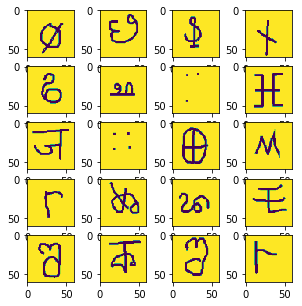

In [10]:
imagePath = glob.glob("{}*/*/*.png".format(PATH))


SZ=60 #Dimension of the output image expected

#Dimensions of the grill of sample pictures
columns = 4
rows = 5

fig=plt.figure(figsize=(5, 5))
list_example = np.random.randint(total_example, size = columns*rows)
pos=0
for i in list_example:
    pos+=1
    img = mpimg.imread(imagePath[i])
    img = resize(img, (SZ,SZ), mode='reflect')
    fig.add_subplot(rows, columns, pos)
    plt.imshow(img)
plt.show()

In [11]:
testPath = glob.glob("{}*/*/*.png".format(PATH_TEST))
testPath[0:5]

['images_evaluation\\Angelic\\character01\\0965_01.png',
 'images_evaluation\\Angelic\\character01\\0965_02.png',
 'images_evaluation\\Angelic\\character01\\0965_03.png',
 'images_evaluation\\Angelic\\character01\\0965_04.png',
 'images_evaluation\\Angelic\\character01\\0965_05.png']

All images seems clear and well centered.

### Image conversion

We convert all images into arrays and resize them to the 60x60 format. We concatenate all arrays into the variable im_array

In [12]:
#Transform in array and resize all 19280 images 
X_train = np.array([resize(mpimg.imread(i), (SZ,SZ), mode='reflect') for i in imagePath] )
print (X_train.shape)

(19280, 60, 60)


We reshape the image to take into account the number of channel to pass them in our CNN, which is 1 here.

In [13]:
channel_sz = 1 #number of channel
X_train= X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],channel_sz)
print(X_train.shape)

(19280, 60, 60, 1)


In [14]:
test_array = np.array([resize(mpimg.imread(i), (SZ,SZ), mode='reflect') for i in testPath] )
print (test_array.shape)

test_array= test_array.reshape(test_array.shape[0],test_array.shape[1],test_array.shape[2],channel_sz)
print(test_array.shape)

(13180, 60, 60)
(13180, 60, 60, 1)


In [15]:
class_char_test=np.array([])
for i in range(13180//20):
    #As each character have 20 examples
    class_char_test= np.concatenate((class_char_test, np.ones(20)*(i+1))) 
class_char_test = class_char_test.astype(int)
print(class_char_test.shape)

class_char_test=class_char_test.reshape(class_char_test.shape[0],1)
print(class_char_test.shape)



(13180,)
(13180, 1)


### Split Train/ validation


We split the traning set into Train and Validation sets of pictures (Train : 70%, Validation : 30%)

In [16]:
#X_train, X_valid, Y_train, Y_valid = train_test_split(im_array, class_char, test_size=0.3, stratify= class_char)

In [17]:
#X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

In [18]:
X_test, X_eval, Y_test, Y_eval = train_test_split(test_array, class_char_test, test_size=0.7, stratify= class_char_test)
X_test.shape, X_eval.shape, Y_test.shape, Y_eval.shape

((3954, 60, 60, 1), (9226, 60, 60, 1), (3954, 1), (9226, 1))

### Triplet loss function

Our loss function is determined by the following triplet loss function

In [19]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 64)
            positive -- the encodings for the positive images, of shape (None, 64)
            negative -- the encodings for the negative images, of shape (None, 64)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[:,0:64], y_pred[:,64:128], y_pred[:,128:256]
    
    #Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1)
    #Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1)
    #Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(basic_loss,0))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    #Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))/ alpha * 100 / (num_positive_triplets + 1e-16)
    
    return loss

In [20]:
def triplet_acc(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 64)
            positive -- the encodings for the positive images, of shape (None, 64)
            negative -- the encodings for the negative images, of shape (None, 64)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[:,0:64], y_pred[:,64:128], y_pred[:,128:256]
    
    #Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1)
    #Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1)
    #Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Count number of positive triplets (where triplet_loss > 0)
    hard_triplets = tf.to_float(tf.greater(basic_loss,alpha))
    num_hard_triplets = tf.reduce_sum(hard_triplets)
    all_triplets = tf.reduce_sum(tf.to_float(tf.greater(basic_loss,-10**10)))
    #Take the maximum of basic_loss and 0.0. Sum over the training examples.
    acc = 1 - num_hard_triplets/all_triplets
    
    return acc

Triplet Creation

In [21]:
def create_triplets(X, Y, num=1):
    """
    Create a list of valid triplets
    
    Arguments:
    X -- array of images
    Y -- array of classes corresponding to each image
    num -- number of negative images for each valid anchor and positive images - must be positive
           if num = 0, all possible valid couples are created
            For example : for one valid (A,P) couple we can select 'num' random N images. 
                          Thus 'num' triplets are created for this (A,P) couple

    
    Returns:
    (A,P,N) -- python tuple containing 3 arrays : 
            A -- the array for the anchor images, of shape (None, 64)
            P -- the array for the positive images, of shape (None, 64)
            N -- the array for the negative images, of shape (None, 64)
    """

    Y = Y.reshape(Y.shape[0],)
    A = []
    P = []
    N = []
    
    #We loop over all possible valid (A,P)
    for i in range(X.shape[0]):  
        list_pos = X[Y==Y[i]]
        for j in list_pos:
            #We provide a number 'num' of triplets for each valid (A,P)
            if num >=1:
                for k in range(num):
                    rand_num = np.random.randint(X.shape[0])
                    if np.array_equal(X[i],j) == False:
                        A.append(X[i])
                        P.append(j)
                        while np.array_equal(Y[rand_num], Y[i]):
                            rand_num = np.random.randint(X.shape[0])
                        N.append(X[rand_num])
            if num == 0:
                for k in range(X.shape[0]):
                    if np.array_equal(X[i],j) == False:
                        if np.array_equal(Y[i],Y[k]) == False:
                            A.append(X[i])
                            P.append(j)
                            N.append(X[k])
    
    A = np.array(A)
    P = np.array(P)
    N = np.array(N)
    
    return (A, P, N)

In [22]:
#We create one triplet for each of the possible (A,P) couple in our validation set 
"""triplets_list_valid = create_triplets(X_valid,Y_valid)
for i in range(len(triplets_list_valid)):
    print(triplets_list_valid[i].shape)"""

'triplets_list_valid = create_triplets(X_valid,Y_valid)\nfor i in range(len(triplets_list_valid)):\n    print(triplets_list_valid[i].shape)'

In [23]:
triplets_list_test = create_triplets(X_test, Y_test)
for i in range(len(triplets_list_test)):
    print(triplets_list_test[i].shape)

(19770, 60, 60, 1)
(19770, 60, 60, 1)
(19770, 60, 60, 1)


This gives us a number of 28920 examples for the validation. Thus 1 negative image per (A,P) couple is enough for our evaluation set.

### Model creation

In [24]:
def EmbModel(input_shape, drop1=0, drop2=1/32):
    """
    Define our shared embedding model
    
    Arguments:
    input_shape -- shape of array of input images

    
    Returns:
    model - Our model which transform an array of images into an array of embeddings
    """
    
    
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)
    
    #Padding
    X = ZeroPadding2D((1,1))(X_input)
    
    #CONV
    X = Conv2D(16,(3,3),strides =(1,1), name ='conv0', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn0") (X)
    X = Activation('relu', name='a0')(X)
    
    #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool0')(X)
    
    X = Dropout(drop1)(X)
    
    #Padding
    #X = ZeroPadding2D((1,1))(X)
    
     #CONV
    X = Conv2D(32,(3,3),strides =(1,1), name ='conv1', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn1") (X)
    X = Activation('relu', name='a1')(X)
    
    #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool1')(X)
    
    X = Dropout(drop1)(X)
    
    #Padding
    #X = ZeroPadding2D((1,1))(X)
    
     #CONV
    X = Conv2D(64,(3,3),strides =(1,1), name ='conv2', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn2") (X)
    X = Activation('relu', name='a2')(X)
    
     #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool2')(X)
    
    X = Dropout(drop1)(X)
    
    #Padding
    #X = ZeroPadding2D((1,1))(X)
    
     #CONV
    X = Conv2D(128,(3,3),strides =(1,1), name ='conv3', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn3") (X)
    X = Activation('relu', name='a3')(X)
    
     #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool3')(X)
    
    #X = Dropout(0.2)(X)
    
    #FLATTEN X + FC
    X = Flatten(name='f3')(X)
    #X = Dense (256, activation ='relu', name='fc4', kernel_initializer='glorot_uniform') (X)
    X = Dropout(drop2)(X)
    X = Dense (64, activation ='relu', name='fc5', kernel_initializer='glorot_uniform') (X)
    X = Lambda(lambda  x: tf.nn.l2_normalize(x,axis=1))(X)
    
    ##Create model
    model = Model(inputs = X_input, outputs = X, name='EmbModel')
    
    return model

#### Global model

In [25]:
#We define our global model
def global_model(size, channel_size=1, drop1=0, drop2=1/32):
    input_size = (size, size, channel_sz)                     

    A = Input(input_size)
    P = Input(input_size)
    N = Input(input_size)

    emb_model= EmbModel(input_size)

    out_A = emb_model(A)
    out_P = emb_model(P)
    out_N = emb_model(N)

    y_pred = concatenate([out_A, out_P, out_N], axis =-1)

    full_model = Model(inputs = [A, P, N], outputs = y_pred)
    
    return full_model, emb_model

In [26]:
def model_fit(model, b_size = 32, ep = 50):

    A,P,N = triplets_list_train
    A_test, P_test, N_test = triplets_list_test
    zeros_vect = np.zeros(A[:,1,1].shape)
    zeros_vect_test = np.zeros(A_test[:,1,1].shape) 
    class_model.fit(x = [A, P, N] , 
                             y = zeros_vect , 
                             batch_size = b_size, 
                             epochs = ep,
                             validation_data = ([A_test, P_test, N_test], zeros_vect_test), 
                             shuffle = True)
    return class_model

In [27]:
classification_model, emb_model = global_model(SZ,channel_sz,drop1 = 0.3, drop2 = 0.3)

In [28]:
classification_model.summary()
emb_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 60, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 60, 60, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 60, 60, 1)    0                                            
__________________________________________________________________________________________________
EmbModel (Model)                (None, 64)           130400      input_1[0][0]                    
                                                                 input_2[0][0]                    
          

## Batch Generator

In [29]:
def batch_generator(X,Y, bs=32):
    """
    Create a mini-batch generator
    
    Arguments:
    X -- array of images
    Y -- array of classes corresponding to each image
    bs -- size of the minibatch

    
    Returns:
    [A_batch, P_batch, N_batch], y_dummie) -- a mini-batch of size bs
    """
    
    Y = Y.reshape(Y.shape[0],)
    while True:
        #0. Initialize Anchor,Postive, Negative
        A_batch = []
        P_batch = []
        N_batch = []
        for i in range(bs):      
            #1.Choose a random Anchor Image
            rand_A_num = np.random.randint(X.shape[0])
            A_batch.append(X[rand_A_num])
            
            #2.Choose a random Positive Image
            list_pos = X[Y==Y[rand_A_num]]                            #List of positive images
            rand_P_num = np.random.randint(len(list_pos))
            P_batch.append(list_pos[rand_P_num])
            
            #3.Choose a random Negative Image
            rand_N_num = np.random.randint(X.shape[0])
            while np.array_equal(Y[rand_N_num], Y[rand_A_num]):
                rand_A_num = np.random.randint(X.shape[0])
            N_batch.append(X[rand_N_num])
            
        A_batch = np.array(A_batch)
        P_batch = np.array(P_batch)
        N_batch = np.array(N_batch)
        
        y_dummie = np.zeros((len(A_batch),))
        
        yield ([A_batch, P_batch, N_batch], y_dummie)

## Real shit

In [30]:
#We compile our model with the custom made triplet_loss
classification_model.compile(optimizer = 'adam', loss = triplet_loss, metrics =[triplet_acc])

### Checkpoint and early stop

In [31]:
#We create a checkpoint to save the best model and add an early stopping
filepath = "Weights/weights.{epoch:03d}-{val_triplet_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_triplet_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_triplet_acc', patience=20, verbose=1, mode='max')
callbacks_list = [checkpoint, early_stop]

In [ ]:
#Full network
A_test, P_test, N_test = triplets_list_test
zeros_vect_test = np.zeros(A_test[:,1,1].shape) 


batch_sz = 32

classification_model.fit_generator(batch_generator(X_train, Y_train, batch_sz), 
                                   steps_per_epoch = 11448,
                                   epochs = 200,
                                   verbose = 1,
                                   validation_data = ([A_test, P_test, N_test], zeros_vect_test)
                                  )

Epoch 1/200
   96/11448 [..............................] - ETA: 52:47 - loss: 81.5795 - triplet_acc: 0.8636

In [88]:
#0.3 ALL
A_test, P_test, N_test = triplets_list_test
zeros_vect_test = np.zeros(A_test[:,1,1].shape) 


batch_sz = 256

classification_model.fit_generator(batch_generator(X_train, Y_train, batch_sz), 
                                   steps_per_epoch = 1432,
                                   epochs = 200,
                                   verbose = 1,
                                   validation_data = ([A_test, P_test, N_test], zeros_vect_test),
                                   callbacks = callbacks_list
                                  )

Epoch 1/200
143/143 [==============================] - 172s 1s/step - loss: 60.7583 - triplet_acc: 0.9963 - val_loss: 78.4933 - val_triplet_acc: 0.9860

Epoch 00001: val_triplet_acc improved from -inf to 0.98599, saving model to Weights/weights.001-0.9860.hdf5
Epoch 2/200
143/143 [==============================] - 172s 1s/step - loss: 59.4852 - triplet_acc: 0.9961 - val_loss: 77.2877 - val_triplet_acc: 0.9848

Epoch 00002: val_triplet_acc did not improve
Epoch 3/200
143/143 [==============================] - 172s 1s/step - loss: 61.6055 - triplet_acc: 0.9967 - val_loss: 75.4602 - val_triplet_acc: 0.9870

Epoch 00003: val_triplet_acc improved from 0.98599 to 0.98700, saving model to Weights/weights.003-0.9870.hdf5
Epoch 4/200
143/143 [==============================] - 172s 1s/step - loss: 59.4632 - triplet_acc: 0.9963 - val_loss: 79.4516 - val_triplet_acc: 0.9859

Epoch 00004: val_triplet_acc did not improve
Epoch 5/200
143/143 [==============================] - 172s 1s/step - loss: 57.

KeyboardInterrupt: 

In [95]:
#1/32 DROPOUT ALL

classification_model, emb_model = global_model(SZ,channel_sz,drop1 = 0, drop2 = 1/32)
classification_model.compile(optimizer = 'adam', loss = triplet_loss, metrics =[triplet_acc])

batch_sz = 256

classification_model.fit_generator(batch_generator(X_train, Y_train, batch_sz), 
                                   steps_per_epoch = 344,
                                   epochs = 200,
                                   verbose = 1,
                                   validation_data = ([A_test, P_test, N_test], zeros_vect_test),
                                   callbacks = callbacks_list
                                  )

Epoch 1/200
344/344 [==============================] - 370s 1s/step - loss: 73.6986 - triplet_acc: 0.9553 - val_loss: 70.9202 - val_triplet_acc: 0.9652

Epoch 00001: val_triplet_acc did not improve
Epoch 2/200
344/344 [==============================] - 363s 1s/step - loss: 66.7036 - triplet_acc: 0.9848 - val_loss: 65.5016 - val_triplet_acc: 0.9738

Epoch 00002: val_triplet_acc did not improve
Epoch 3/200
344/344 [==============================] - 363s 1s/step - loss: 65.5337 - triplet_acc: 0.9894 - val_loss: 72.0153 - val_triplet_acc: 0.9762

Epoch 00003: val_triplet_acc did not improve
Epoch 4/200
344/344 [==============================] - 362s 1s/step - loss: 65.1847 - triplet_acc: 0.9911 - val_loss: 74.1553 - val_triplet_acc: 0.9818

Epoch 00004: val_triplet_acc did not improve
Epoch 5/200
344/344 [==============================] - 363s 1s/step - loss: 62.3307 - triplet_acc: 0.9930 - val_loss: 67.7295 - val_triplet_acc: 0.9795

Epoch 00005: val_triplet_acc did not improve
Epoch 6/20

KeyboardInterrupt: 

In [96]:
#0.4 DROPOUT ALL

classification_model, emb_model = global_model(SZ,channel_sz,drop1 = 0.4, drop2 = 0.4)
classification_model.compile(optimizer = 'adam', loss = triplet_loss, metrics =[triplet_acc])

batch_sz = 256

classification_model.fit_generator(batch_generator(X_train, Y_train, batch_sz), 
                                   steps_per_epoch = 344,
                                   epochs = 200,
                                   verbose = 1,
                                   validation_data = ([A_test, P_test, N_test], zeros_vect_test),
                                   callbacks = callbacks_list
                                  )

Epoch 1/200
344/344 [==============================] - 368s 1s/step - loss: 73.8831 - triplet_acc: 0.9555 - val_loss: 76.0018 - val_triplet_acc: 0.9640

Epoch 00001: val_triplet_acc did not improve
Epoch 2/200
344/344 [==============================] - 362s 1s/step - loss: 68.4087 - triplet_acc: 0.9843 - val_loss: 81.3286 - val_triplet_acc: 0.9734

Epoch 00002: val_triplet_acc did not improve
Epoch 3/200
344/344 [==============================] - 362s 1s/step - loss: 64.8603 - triplet_acc: 0.9892 - val_loss: 71.3560 - val_triplet_acc: 0.9803

Epoch 00003: val_triplet_acc did not improve
Epoch 4/200
344/344 [==============================] - 363s 1s/step - loss: 66.5147 - triplet_acc: 0.9909 - val_loss: 77.9457 - val_triplet_acc: 0.9780

Epoch 00004: val_triplet_acc did not improve
Epoch 5/200
344/344 [==============================] - 362s 1s/step - loss: 66.7208 - triplet_acc: 0.9921 - val_loss: 68.8181 - val_triplet_acc: 0.9773

Epoch 00005: val_triplet_acc did not improve
Epoch 6/20

KeyboardInterrupt: 

### Double FC


In [ ]:
def EmbModel(input_shape, drop1=0, drop2=1/32):
    """
    Define our shared embedding model
    
    Arguments:
    input_shape -- shape of array of input images

    
    Returns:
    model - Our model which transform an array of images into an array of embeddings
    """
    
    
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)
    
    #Padding
    X = ZeroPadding2D((1,1))(X_input)
    
    #CONV
    X = Conv2D(16,(3,3),strides =(1,1), name ='conv0', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn0") (X)
    X = Activation('relu', name='a0')(X)
    
    #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool0')(X)
    
    X = Dropout(drop1)(X)
    
    #Padding
    #X = ZeroPadding2D((1,1))(X)
    
     #CONV
    X = Conv2D(32,(3,3),strides =(1,1), name ='conv1', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn1") (X)
    X = Activation('relu', name='a1')(X)
    
    #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool1')(X)
    
    X = Dropout(drop1)(X)
    
    #Padding
    #X = ZeroPadding2D((1,1))(X)
    
     #CONV
    X = Conv2D(64,(3,3),strides =(1,1), name ='conv2', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn2") (X)
    X = Activation('relu', name='a2')(X)
    
     #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool2')(X)
    
    X = Dropout(drop1)(X)
    
    #Padding
    #X = ZeroPadding2D((1,1))(X)
    
     #CONV
    X = Conv2D(128,(3,3),strides =(1,1), name ='conv3', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn3") (X)
    X = Activation('relu', name='a3')(X)
    
     #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool3')(X)
    
    X = Dropout(drop1)(X)
    
    #FLATTEN X + FC
    X = Flatten(name='f3')(X)
    X = Dense (64, activation ='relu', name='fc4', kernel_initializer='glorot_uniform') (X)
    X = Dropout(drop2)(X)
    X = Dense (64, activation ='relu', name='fc5', kernel_initializer='glorot_uniform') (X)
    X = Lambda(lambda  x: tf.nn.l2_normalize(x,axis=1))(X)
    
    ##Create model
    model = Model(inputs = X_input, outputs = X, name='EmbModel')
    
    return model

In [ ]:
#We define our global model
def global_model(size, channel_size=1, drop1=0, drop2=1/32):
    input_size = (size, size, channel_sz)                     

    A = Input(input_size)
    P = Input(input_size)
    N = Input(input_size)

    emb_model= EmbModel(input_size)

    out_A = emb_model(A)
    out_P = emb_model(P)
    out_N = emb_model(N)

    y_pred = concatenate([out_A, out_P, out_N], axis =-1)

    full_model = Model(inputs = [A, P, N], outputs = y_pred)
    
    return full_model, emb_model

In [ ]:
def model_fit(model, b_size = 32, ep = 50):

    A,P,N = triplets_list_train
    A_test, P_test, N_test = triplets_list_test
    zeros_vect = np.zeros(A[:,1,1].shape)
    zeros_vect_test = np.zeros(A_test[:,1,1].shape) 
    class_model.fit(x = [A, P, N] , 
                             y = zeros_vect , 
                             batch_size = b_size, 
                             epochs = ep,
                             validation_data = ([A_test, P_test, N_test], zeros_vect_test), 
                             shuffle = True)
    return class_model

In [ ]:
#We create a checkpoint to save the best model and add an early stopping
filepath = "Weights/weights.{epoch:03d}-{val_triplet_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_triplet_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_triplet_acc', patience=20, verbose=1, mode='max')
callbacks_list = [checkpoint, early_stop]

In [ ]:
#1/32 DROPOUT ALL

classification_model, emb_model = global_model(SZ,channel_sz,drop1 = 0.2, drop2 = 0.4)
classification_model.compile(optimizer = 'adam', loss = triplet_loss, metrics =[triplet_acc])

batch_sz = 256

classification_model.fit_generator(batch_generator(X_train, Y_train, batch_sz), 
                                   steps_per_epoch = 344,
                                   epochs = 200,
                                   verbose = 1,
                                   validation_data = ([A_test, P_test, N_test], zeros_vect_test),
                                   callbacks = callbacks_list
                                  )

In [101]:
classification_model.load_weights("Weights/weights.052-0.9899.hdf5")

In [91]:

classification_model.evaluate([A_test, P_test, N_test], zeros_vect_test, verbose=1)

19770/19770 [==============================] - 48s 2ms/step


[52.97960219096221, 0.9870005057807154]

### Return

Comparison with Modified Hausdorff Distance

In [97]:
from demo_classification import *

In [98]:
def CNNDistance(itemA, itemB):
    itemA = itemA.reshape(1, itemA.shape[0], itemA.shape[1], 1)
    itemB = itemB.reshape(1, itemB.shape[0], itemB.shape[1], 1)
    itemA_emb = emb_model.predict_on_batch(itemA)
    itemB_emb = emb_model.predict_on_batch(itemB)
    dist = np.linalg.norm(itemA_emb - itemB_emb) #2-norm by default
    return dist

In [99]:
def LoadImgAsArray(fn):
	# Load image file, return as array and resize
    picture = mpimg.imread(fn)
    image = resize(picture, (SZ,SZ), mode='constant')
    return image

In [102]:
print ('One-shot classification with Modified Hausdorff Distance versus Siamese triplet loss Distance')
perror = np.zeros(nrun)
perror_cnn =np.zeros(nrun)
for r in range(1,nrun+1):
	rs = str(r)
	if len(rs)==1:
		rs = '0' + rs		
	perror[r-1] = classification_run('one-shot-classification','/run'+rs, LoadImgAsPoints, ModHausdorffDistance, 'cost')
	perror_cnn[r-1] = classification_run('one-shot-classification','run'+rs, LoadImgAsArray, CNNDistance, 'cost')
	print (" run " + str(r) + " ModHausdorffDistance" + "(error " + str(	perror[r-1] ) + "%)"+ "  -  Siamese_triplet_loss_Distance" + " (error " + str(	perror_cnn[r-1] ) + "%)")		
total = np.mean(perror)
total_cnn = np.mean(perror_cnn)
print (" average error ModHausdorffDistance " + str(total) + "%" + "  average error Siamese_triplet_loss_Distance " + str(total_cnn) + "%")

One-shot classification with Modified Hausdorff Distance versus Siamese triplet loss Distance
 run 1 ModHausdorffDistance(error 45.0%)  -  Siamese_triplet_loss_Distance (error 20.0%)
 run 2 ModHausdorffDistance(error 35.0%)  -  Siamese_triplet_loss_Distance (error 30.0%)
 run 3 ModHausdorffDistance(error 40.0%)  -  Siamese_triplet_loss_Distance (error 15.0%)
 run 4 ModHausdorffDistance(error 25.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 5 ModHausdorffDistance(error 30.0%)  -  Siamese_triplet_loss_Distance (error 0.0%)
 run 6 ModHausdorffDistance(error 15.0%)  -  Siamese_triplet_loss_Distance (error 0.0%)
 run 7 ModHausdorffDistance(error 60.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 8 ModHausdorffDistance(error 35.0%)  -  Siamese_triplet_loss_Distance (error 30.0%)
 run 9 ModHausdorffDistance(error 40.0%)  -  Siamese_triplet_loss_Distance (error 15.0%)
 run 10 ModHausdorffDistance(error 55.0%)  -  Siamese_triplet_loss_Distance (error 40.0%)
 run 11 ModHausdo

In [105]:
##dropout 0.1 all early stop

print ('One-shot classification with Modified Hausdorff Distance versus Siamese triplet loss Distance')
perror = np.zeros(nrun)
perror_cnn =np.zeros(nrun)
for r in range(1,nrun+1):
	rs = str(r)
	if len(rs)==1:
		rs = '0' + rs		
	perror[r-1] = classification_run('one-shot-classification','/run'+rs, LoadImgAsPoints, ModHausdorffDistance, 'cost')
	perror_cnn[r-1] = classification_run('one-shot-classification','run'+rs, LoadImgAsArray, CNNDistance, 'cost')
	print (" run " + str(r) + " ModHausdorffDistance" + "(error " + str(	perror[r-1] ) + "%)"+ "  -  Siamese_triplet_loss_Distance" + " (error " + str(	perror_cnn[r-1] ) + "%)")		
total = np.mean(perror)
total_cnn = np.mean(perror_cnn)
print (" average error ModHausdorffDistance " + str(total) + "%" + "  average error Siamese_triplet_loss_Distance " + str(total_cnn) + "%")

One-shot classification with Modified Hausdorff Distance versus Siamese triplet loss Distance
 run 1 ModHausdorffDistance(error 45.0%)  -  Siamese_triplet_loss_Distance (error 20.0%)
 run 2 ModHausdorffDistance(error 35.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 3 ModHausdorffDistance(error 40.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 4 ModHausdorffDistance(error 25.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 5 ModHausdorffDistance(error 30.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 6 ModHausdorffDistance(error 15.0%)  -  Siamese_triplet_loss_Distance (error 5.0%)
 run 7 ModHausdorffDistance(error 60.0%)  -  Siamese_triplet_loss_Distance (error 15.0%)
 run 8 ModHausdorffDistance(error 35.0%)  -  Siamese_triplet_loss_Distance (error 15.0%)
 run 9 ModHausdorffDistance(error 40.0%)  -  Siamese_triplet_loss_Distance (error 25.0%)
 run 10 ModHausdorffDistance(error 55.0%)  -  Siamese_triplet_loss_Distance (error 35.0%)
 run 11 ModHausd

In [52]:
##dropout 0.1 best model

print ('One-shot classification with Modified Hausdorff Distance versus Siamese triplet loss Distance')
perror = np.zeros(nrun)
perror_cnn =np.zeros(nrun)
for r in range(1,nrun+1):
	rs = str(r)
	if len(rs)==1:
		rs = '0' + rs		
	perror[r-1] = classification_run('one-shot-classification','/run'+rs, LoadImgAsPoints, ModHausdorffDistance, 'cost')
	perror_cnn[r-1] = classification_run('one-shot-classification','run'+rs, LoadImgAsArray, CNNDistance, 'cost')
	print (" run " + str(r) + " ModHausdorffDistance" + "(error " + str(	perror[r-1] ) + "%)"+ "  -  Siamese_triplet_loss_Distance" + " (error " + str(	perror_cnn[r-1] ) + "%)")		
total = np.mean(perror)
total_cnn = np.mean(perror_cnn)
print (" average error ModHausdorffDistance " + str(total) + "%" + "  average error Siamese_triplet_loss_Distance " + str(total_cnn) + "%")

One-shot classification with Modified Hausdorff Distance versus Siamese triplet loss Distance
 run 1 ModHausdorffDistance(error 45.0%)  -  Siamese_triplet_loss_Distance (error 25.0%)
 run 2 ModHausdorffDistance(error 35.0%)  -  Siamese_triplet_loss_Distance (error 15.0%)
 run 3 ModHausdorffDistance(error 40.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 4 ModHausdorffDistance(error 25.0%)  -  Siamese_triplet_loss_Distance (error 15.0%)
 run 5 ModHausdorffDistance(error 30.0%)  -  Siamese_triplet_loss_Distance (error 20.0%)
 run 6 ModHausdorffDistance(error 15.0%)  -  Siamese_triplet_loss_Distance (error 5.0%)
 run 7 ModHausdorffDistance(error 60.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 8 ModHausdorffDistance(error 35.0%)  -  Siamese_triplet_loss_Distance (error 15.0%)
 run 9 ModHausdorffDistance(error 40.0%)  -  Siamese_triplet_loss_Distance (error 20.0%)
 run 10 ModHausdorffDistance(error 55.0%)  -  Siamese_triplet_loss_Distance (error 40.0%)
 run 11 ModHausd

In [30]:
testPath = glob.glob("{}*/*/*.png".format(PATH_TEST))
testPath[0:5]

['images_evaluation/Glagolitic/character02/1116_09.png',
 'images_evaluation/Glagolitic/character02/1116_03.png',
 'images_evaluation/Glagolitic/character02/1116_15.png',
 'images_evaluation/Glagolitic/character02/1116_08.png',
 'images_evaluation/Glagolitic/character02/1116_17.png']

(13180, 60, 60)


In [33]:
test_array= test_array.reshape(test_array.shape[0],test_array.shape[1],test_array.shape[2],channel_sz)
print(test_array.shape)

(13180, 60, 60, 1)


In [34]:
class_char_test=np.array([])
for i in range(13180//20):
    #As each character have 20 examples
    class_char_test= np.concatenate((class_char_test, np.ones(20)*(i+1))) 
class_char_test = class_char_test.astype(int)
print(class_char_test.shape)

(13180,)


In [35]:
class_char_test=class_char_test.reshape(class_char_test.shape[0],1)
print(class_char_test.shape)

(13180, 1)


In [37]:
X_test, X_eval, Y_test, Y_eval = train_test_split(test_array, class_char_test, test_size=0.7, stratify= class_char_test)

In [46]:
triplets_list_eval = create_triplets(X_eval, Y_eval)

In [47]:
A_eval, P_eval, N_eval = triplets_list_eval
zeros_vect_eval = np.zeros(A_eval[:,1,1].shape) 

classification_model.evaluate([A_eval, P_eval, N_eval], zeros_vect_eval, verbose=1)



119938/119938 [==============================] - 145s 1ms/step


2.8782454858518958